## Creating synthetic data defined from Gaussian distributions

In [1]:
# PyTorch Imports
import torch
import torch.nn as nn
from torch.nn import Module
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.distributions import Normal

# Basic Python Imports
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans

# Module Imports
from BayesLinear import BayesLinear
from Loss import BKLLoss

import random
from sklearn.preprocessing import StandardScaler

random.seed(10)

C:\Users\jensl\anaconda3\envs\bachellor\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


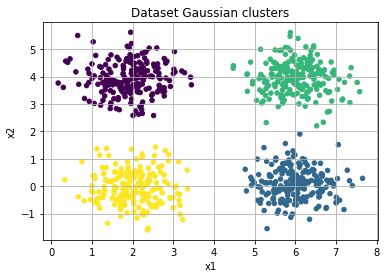

In [2]:
center_locations = [[0, 2], [4, 2], [0, 6], [4, 6]]
X, y_true = make_blobs(n_samples=800, centers=center_locations,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

# Plot the data with K Means Labels
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.subplots()
plt.scatter(X[:, 0], X[:, 1], c=labels, s=20, cmap='viridis')
plt.grid()
plt.title('Dataset Gaussian clusters')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

In [3]:
# create gaussian distributed labels
mu = [0, 8, 4, 12]
sigma = [0.5, 0.7, 0.9, 1.1]

labels = labels.astype(float)
size1 = np.where(labels==0)[0]
size2 = np.where(labels==1)[0]
size3 = np.where(labels==2)[0]
size4 = np.where(labels==3)[0]
s1 = np.random.normal(loc=mu[0], scale=sigma[0], size=len(size1))
s2 = np.random.normal(mu[1], sigma[1], len(size1))
s3 = np.random.normal(mu[2], sigma[2], len(size2))
s4 = np.random.normal(mu[3], sigma[3], len(size3))

#replace categorical labels with distribution
labels[size1] = s1
labels[size2] = s2
labels[size3] = s3
labels[size4] = s4

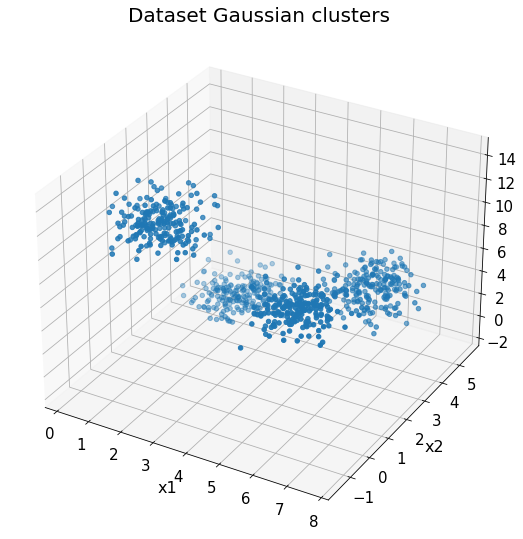

In [4]:
# plot 3D scatter data.
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(14,7))
ax = Axes3D(fig)
ax.scatter(X[:, 0], X[:, 1], labels)
plt.grid()
plt.title('Dataset Gaussian clusters', fontsize=20)
plt.xlabel('x1', fontsize=16)
plt.ylabel('x2', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.zaxis.set_tick_params(labelsize=15)
plt.show()

In [5]:
class Net(Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden1 = BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=n_feature, out_features=n_hidden, bias=True)   # hidden layer
        self.hidden2 = BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=n_hidden, out_features=n_hidden, bias=True)
        self.predict = BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=n_hidden, out_features=n_output, bias=True)   # output layer
        
    def forward(self, x):
        x = torch.tanh(self.hidden1(x))      # activation function for hidden layer
        x = torch.tanh(self.hidden2(x))
        x = self.predict(x)              # linear output
        
        mu, log_std = x.chunk(2, dim=1)        
        dist = Normal(mu, torch.exp(log_std))

        return dist
    
net = Net(n_feature=2, n_hidden=50, n_output=2)     # define the network
print(net)  # net architecture

Net(
  (hidden1): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=2, out_features=50, bias=True)
  (hidden2): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=50, out_features=50, bias=True)
  (predict): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=50, out_features=2, bias=True)
)


In [6]:
xx = X.copy()
x = torch.from_numpy(xx)
y = torch.from_numpy(labels)

x = x.float()
y = y.float()

print(y.shape)
print(x.shape)

torch.Size([800])
torch.Size([800, 2])


In [7]:
net = net.float()

optimizer = optim.Adam(net.parameters(),  lr=0.001)

kl_loss = BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.01

for t in range(1000):
    
    optimizer.zero_grad()

    distribution = net(x.float())
    
    kl = kl_loss(net)

    cost = -distribution.log_prob(y.float()).sum(1).mean() + kl_weight*kl
    
    cost.backward()
    
    optimizer.step()
    
print('- MSE : %2.2f, KL : %2.2f' % (cost.item(), kl.item()))

- MSE : 2920.57, KL : 2.32


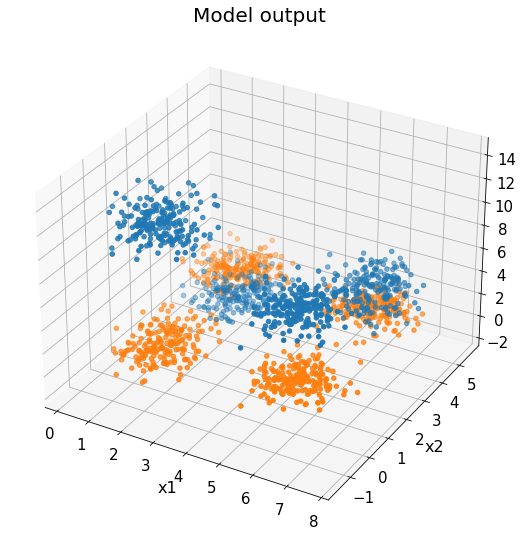

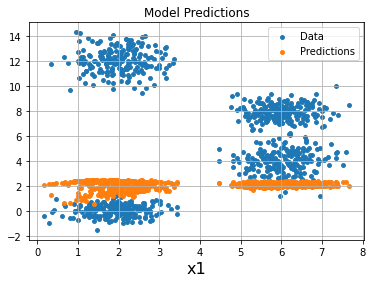

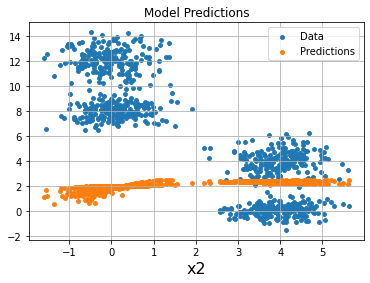

In [13]:
prediction = net(x.float())
mean = prediction.loc.squeeze().detach().numpy()
std = prediction.scale.squeeze().detach().numpy()

fig = plt.figure(figsize=(14,7))
ax = Axes3D(fig)
ax.scatter(X[:, 0], X[:, 1], labels, label='Data')
ax.scatter(X[:, 0], X[:, 1], mean, label='Predictions')
plt.grid()
plt.title('Model output', fontsize=20)
plt.xlabel('x1', fontsize=16)
plt.ylabel('x2', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.zaxis.set_tick_params(labelsize=15)
plt.show()


plt.figure()
plt.scatter(X[:, 0], y, s=15, label='Data')
plt.scatter(X[:, 0], mean, s=15, label='Predictions')
plt.title('Model Predictions')
plt.xlabel('x1', fontsize=16)
plt.grid()
plt.legend()
plt.show()

plt.figure()
plt.scatter(X[:, 1], y, s=15, label='Data')
plt.scatter(X[:, 1], mean, s=15, label='Predictions')
plt.title('Model Predictions')
plt.xlabel('x2', fontsize=16)
plt.grid()
plt.legend()
plt.show()